# Random Forest Model

Idea: Build many decision trees

Each tree sees: random subset of data + random subset of features

Final prediction = average of trees

Characteristics:

- Strong non-linear modeling
- Handles mixed features well
- Less tuning than boosting

But:

- big models
- slower
- usually worse than boosting for tabular data

In insurance:

- Very common baseline production model
- Often replaced by boosting when performance matters

### 1 — Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier


### 2 — Load data and split

Keep -1 values (RF cannot handle NaN).

In [3]:
train = pd.read_csv("train.csv")

X = train.drop(columns=["id", "target"])
y = train["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### 3 — Baseline Random Forest

In [4]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

### 4 — Evaluate

In [5]:
val_pred = rf.predict_proba(X_val)[:,1]
roc = roc_auc_score(y_val, val_pred)
roc


0.6313647012753786

### 5 — Feature Importance

In [6]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top20 = importances.sort_values(ascending=False).head(20)

top20


ps_car_13        0.096355
ps_reg_03        0.065110
ps_ind_05_cat    0.059528
ps_ind_03        0.042874
ps_reg_02        0.042732
ps_ind_17_bin    0.040699
ps_car_14        0.038137
ps_car_12        0.031100
ps_ind_15        0.030754
ps_car_07_cat    0.026636
ps_car_04_cat    0.025114
ps_car_15        0.024808
ps_car_11_cat    0.022670
ps_car_01_cat    0.022647
ps_reg_01        0.021963
ps_ind_01        0.020934
ps_car_03_cat    0.020570
ps_car_06_cat    0.019996
ps_calc_14       0.019616
ps_calc_10       0.019066
dtype: float64

<Axes: title={'center': 'Top 20 Feature Importances (Random Forest)'}>

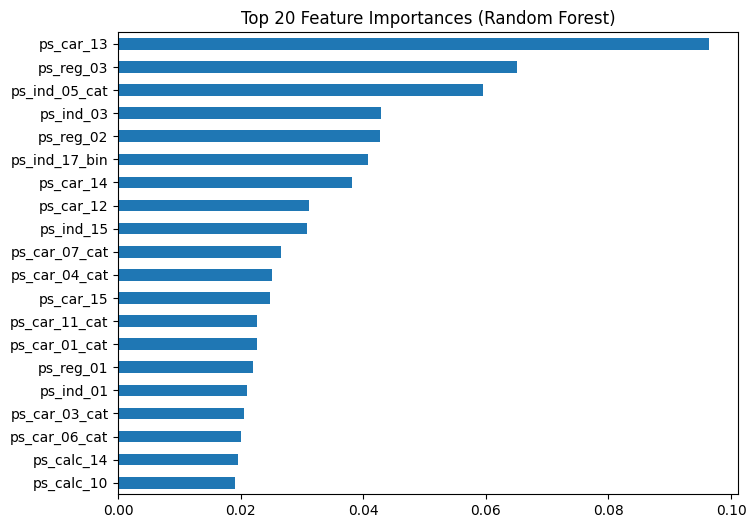

In [7]:
top20.sort_values().plot(kind="barh", figsize=(8,6), title="Top 20 Feature Importances (Random Forest)")


| Feature       | Group | Interpretation                                 |
| ------------- | ----- | ---------------------------------------------- |
| ps_car_13     | car   | vehicle characteristic strongly linked to risk |
| ps_reg_03     | reg   | regional factor / geography                    |
| ps_ind_05_cat | ind   | individual attribute                           |
| ps_ind_03     | ind   | driver attribute                               |
| ps_reg_02     | reg   | regional info                                  |
| ps_ind_17_bin | ind   | binary driver flag                             |
| ps_car_14     | car   | vehicle spec                                   |
| ps_car_12     | car   | vehicle spec                                   |


- **Vehicle features matter a lot**
- **Region matters**
- **Driver profile matters**
- calc_* features are less important (mostly lower in ranking)

Risk is driven primarily by vehicle characteristics, driver attributes, and geographic factors, rather than engineered actuarial calculations alone.

### 7 — Observations

| Model                    | ROC-AUC    |
| ------------------------ | ---------- |
| Random guessing          | 0.50       |
| KNN                      | ~0.53      |
| Random Forest            | **~0.63**  |
| Boosted Trees (expected) | ~0.67–0.70 |


Tree-based models capture non-linear interactions between customer, vehicle, and regional features that distance-based models fail to learn, significantly improving risk ranking.

Performance:
- Run-time is excellent (8s) for 600k rows and 100 trees.
- Real-time or batch scoring is feasible
- Model complexity is operationally reasonable
- This supports RF as a viable production candidate --> **strong baseline vs boosting models.**

### 8 — Fine-tuning

Increasing the trees from 100 to 300. Meaningful increase would be ROC AUC + 0.01.

In [13]:
rf2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=30,
    n_jobs=-1,
    random_state=42
)

rf2.fit(X_train, y_train)

val_pred2 = rf2.predict_proba(X_val)[:,1]
roc = roc_auc_score(y_val, val_pred2)
roc


0.6323763274284292

| Model                     | ROC-AUC    | Train Time |
| ------------------------- | ---------- | ---------- |
| RF v1 (100 trees)         | 0.6314     | ~8 s       |
| RF v2 (300 trees, deeper) | **0.6324** | **~24 s**  |


- Improvement: ROC-AUC gain ≈ +0.001

- Cost: Training time 3× longer

Increasing model complexity led to negligible performance gains while significantly increasing training cost, indicating that further Random Forest tuning is not cost-effective.

| Experiment | Change              | Result                   | Decision             |
| ---------- | ------------------- | ------------------------ | -------------------- |
| RF v1      | 100 trees, depth 10 | ROC-AUC 0.631            | Strong baseline      |
| RF v2      | 300 trees, deeper   | ROC-AUC 0.632, 3× slower | Not worth complexity |
